In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

#This line will hide code by default when the notebook is exported as HTML
#di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

display(HTML("<style>.container { width:100% !important; }</style>"))

import hail as hl
hl.init(tmp_dir='/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/temp', spark_conf={'spark.driver.memory': '30G', 'spark.executor.memory': '30G'}, default_reference='GRCh38') 

2022-01-05 10:41:14 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.1.2
SparkUI available at http://p1855.prometheus:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.79-f141af259254
LOGGING: writing to /net/archive/groups/plggneuromol/imdik-zekanowski-gts/analysis/burden-and-family/hail-20220105-1041-0.2.79-f141af259254.log


In [2]:
from hail.plot import show
from pprint import pprint
from bokeh.layouts import gridplot
hl.plot.output_notebook()
import openpyxl


import numpy as np
import pandas as pd
from functools import reduce
from itertools import chain

from bokeh.plotting import output_notebook, show, figure
from bokeh.palettes import viridis
import seaborn as sns, matplotlib.pyplot as plt

from scipy import stats

output_notebook() 

Loading BokehJS ...

Loading BokehJS ...

## 1. Load large matrix table, annotate with GTS phenotype, remove samples from families and run PCA

In [ ]:
mt = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-sportwgs/data/joint/full.mt')

pheno = hl.import_table('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/pheno/GTS-coded-corrected-june-2021.csv', impute = True, key='ID', delimiter = ',', quote ="\"")

mt = mt.annotate_cols(phenotypes = pheno[mt.s])

mt = mt.filter_cols((mt.s.contains('HG')) | (mt.s.contains('B')) | (mt.s.contains('NA')) | (mt.phenotypes.family == '.'))

mt = mt.filter_rows(hl.agg.any(mt.GT.is_non_ref()))

mt.write('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/gts-for-burden.mt') #this has been deleted

mt = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/gts-for-burden.mt')

mt = mt.annotate_cols(group = hl.if_else(mt.s.contains('B'), 'sport', hl.if_else(((mt.s.contains('NA')) | (mt.s.contains('HG'))), '1kg', 'GTS')))

subset = mt.sample_rows(0.001)

subset.aggregate_cols(hl.agg.counter(subset.group)) 

subset.write('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/to-delete-for-pca')

subset = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/to-delete-for-pca')

eigenvalues, pcs, _ = hl.hwe_normalized_pca(subset.GT)
subset = subset.annotate_cols(scores = pcs[subset.s].scores)

subset.write('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/to-delete-with-pca')

subset = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/to-delete-with-pca')

p = hl.plot.scatter(subset.scores[2],
                    subset.scores[3],
                    label=subset.group,
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

## 2. Only keep intragenic variants and remove outliers from main mt

In [ ]:
mt = mt.filter_rows(mt.within_gene == hl.empty_array(hl.tstr), keep = False)

mt = mt.filter_cols((mt.s != 'WGS_5') & (mt.s != 'WGS_8'))

## 3. Run sample and variant QC, make plots

In [ ]:
mt.naive_coalesce(2500).write('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/to-delete-repart.mt')

mt = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/to-delete-repart.mt')

mt = hl.sample_qc(mt)
mt = hl.variant_qc(mt)

mt.write('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/for-burden.mt')

mt = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/for-burden.mt')

mt.count()

mt = mt.filter_cols(mt.s != 'WGS_6827')

mt.aggregate_cols(hl.agg.counter(mt.group)) 

#check gq group

mt = mt.annotate_rows(variant_qc_per_grop = hl.agg.group_by(mt.group, hl.agg.stats(mt.GQ)))

p = hl.plot.histogram(mt.variant_qc_per_grop['1kg'].mean, range=(10,100), legend='Mean variant GQ 1kg')
show(p)

p2 = hl.plot.histogram(mt.variant_qc_per_grop['sport'].mean, range=(10,100), legend='Mean variant GQ sport')
show(p2)

p3 = hl.plot.histogram(mt.variant_qc_per_grop.get('GTS', hl.struct(mean = 0.0, stdev = 0.0, min = 0.0, max = 0.0, n = 0, sum = 0)).mean, range=(10,100), legend='Mean variant GQ gts')
show(p3)

## 3. Explode rows, group by gene and calculate multiple burden statistics

In [ ]:
mt = mt.explode_rows(mt.within_gene)
mt.write('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/to-delete-exploded.mt')

#annotate each variant with a burden score:
mt = mt.annotate_rows(burden_maf = hl.if_else(hl.is_defined(mt.gnomad_v_3_1.freq.AF[2]),
                                                  hl.if_else((mt.gnomad_v_3_1.freq.AF[2] == 0), 5, -hl.log10(mt.gnomad_v_3_1.freq.AF[2])), 5),
                      burden_cadd = (2**mt.cadd.cadd_score)) #this is to proiritise variants with high deleteriousness

mt.write('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/to-delete-with-burden-scores.mt')

mt = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/mts/burden-and-family/to-delete-with-burden-scores.mt')

per_gene = mt.group_rows_by(mt.within_gene).aggregate(
    burden_cadd_phred = hl.agg.sum(mt.GT.n_alt_alleles()*mt.cadd.cadd_score))

per_gene.write('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/results/burden-and-family/scores.mt')

per_gene = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/results/burden-and-family/scores.mt')

eigenvalues, scores, _ = hl.pca(per_gene.burden_cadd_phred, k=4)

per_gene = per_gene.annotate_cols(scores = scores[per_gene.s].scores)

In [ ]:
p = hl.plot.scatter(per_gene.scores[0],
                    per_gene.scores[1],
                    label=per_gene.group,
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

In [ ]:
per_gene = per_gene.annotate_rows(stat = hl.agg.group_by(per_gene.group, hl.agg.stats(per_gene.burden_cadd_phred)))

## 4. Run actual burden tests

In [4]:
gene_lists = pd.read_csv('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/data/external-data/burden-and-family/gene-lists-burden-and-family.csv', delimiter = ';')

gene_lists = gene_lists.fillna('')

genes = []

for i in gene_lists.columns:
    genes.append(list(gene_lists[i]))

per_gene = hl.read_matrix_table('/net/archive/groups/plggneuromol/imdik-zekanowski-gts/results/burden-and-family/scores.mt')

In [8]:
per_gene = per_gene.annotate_rows(cc = hl.literal(genes[0]).contains(per_gene.within_gene),
                                  bg = hl.literal(genes[1]).contains(per_gene.within_gene),
                                  hp = hl.literal(genes[2]).contains(per_gene.within_gene),
                                  t = hl.literal(genes[3]).contains(per_gene.within_gene),
                                  mb = hl.literal(genes[4]).contains(per_gene.within_gene),
                                  dop = hl.literal(genes[5]).contains(per_gene.within_gene),
                                  ser = hl.literal(genes[6]).contains(per_gene.within_gene),
                                  nor = hl.literal(genes[7]).contains(per_gene.within_gene),
                                  gaba = hl.literal(genes[8]).contains(per_gene.within_gene),
                                  slit = hl.literal(genes[9]).contains(per_gene.within_gene),
                                  nt = hl.literal(genes[10]).contains(per_gene.within_gene),
                                  glut = hl.literal(genes[11]).contains(per_gene.within_gene),
                                  sc = hl.literal(genes[12]).contains(per_gene.within_gene),
                                  da = hl.literal(genes[13]).contains(per_gene.within_gene),
                                  gts = hl.literal(genes[14]).contains(per_gene.within_gene),
                                  syn = hl.literal(genes[15]).contains(per_gene.within_gene),
                                  trp = hl.literal(genes[16]).contains(per_gene.within_gene),
                                  lr = hl.literal(genes[17]).contains(per_gene.within_gene),
                                  ca = hl.literal(genes[18]).contains(per_gene.within_gene),
                                  andr = hl.literal(genes[19]).contains(per_gene.within_gene),
                                  add = hl.literal(genes[20]).contains(per_gene.within_gene))

filters = [per_gene.cc, per_gene.bg, per_gene.hp, per_gene.t, per_gene.mb,
           per_gene.dop, per_gene.ser, per_gene.nor, per_gene.gaba, per_gene.slit, 
           per_gene.nt, per_gene.glut, per_gene.sc, per_gene.da, per_gene.gts, per_gene.syn, per_gene.trp,
           per_gene.lr, per_gene.ca, per_gene.andr, per_gene.add]                        

groups = per_gene.group.collect()

results_list = []
for f in filters: 
    results = per_gene.filter_rows(f)
    results = results.annotate_cols(result_score = hl.agg.sum(results['burden_cadd_phred']))
    results_list.append(results.result_score.collect())

from scipy import stats

t_test_gts_sport = []
t_test_gts_1kg = []
t_test_sport_1kg = []
gts_mean = []
gts_std = []
kg_mean = []
kg_std = []
sport_mean = []
sport_std = []

for idx, i in enumerate(list(gene_lists.columns)):
    x = np.array(results_list[idx])[np.array(groups) == 'GTS']
    y = np.array(results_list[idx])[np.array(groups) == 'sport']
    t_test_gts_sport.append(stats.ttest_ind(x,y))
    x = np.array(results_list[idx])[np.array(groups) == 'GTS']
    y = np.array(results_list[idx])[np.array(groups) == '1kg']
    t_test_gts_1kg.append(stats.ttest_ind(x,y))
    x = np.array(results_list[idx])[np.array(groups) == 'sport']
    y = np.array(results_list[idx])[np.array(groups) == '1kg']
    t_test_sport_1kg.append(stats.ttest_ind(x,y))
    gts_mean.append(np.mean((np.array(results_list[idx])[np.array(groups) == 'GTS'])))
    gts_std.append(np.std(np.array(results_list[idx])[np.array(groups) == 'GTS']))
    kg_mean.append(np.mean((np.array(results_list[idx])[np.array(groups) == '1kg'])))
    kg_std.append(np.std(np.array(results_list[idx])[np.array(groups) == '1kg']))
    sport_mean.append(np.mean((np.array(results_list[idx])[np.array(groups) == 'sport'])))
    sport_std.append(np.std(np.array(results_list[idx])[np.array(groups) == 'sport']))

In [25]:
np.save('results_list_array', np.array(results_list))

In [27]:
res = np.load('results_list_array.npy')

In [38]:
results_to_plot = pd.DataFrame(res).transpose()

results_to_plot['group'] = pd.Series(np.array(groups))

results_to_plot.columns = ['Cerebral_Cortex',
 'Basal_Ganglia',
 'Hypothalmus',
 'Thalmus',
 'Midbrain',
 'Dopaminergiczna',
 'Serotoninergiczna',
 'Noradrenergiczna',
 'GABA',
 'SLITRK',
 'all_neurotransmitters',
 'Gutaminian',
 'Serotonina_Kannabinoidy',
 'Dopamina_Acetylocholina',
 'geny_GTS',
 'Synapsy',
 'Tryptofan',
 'Ligand_receptor',
 'calcium',
 'androgenowy',
 'addiction', 'groups']

In [45]:
results_to_plot

,Cerebral_Cortex,Basal_Ganglia,Hypothalmus,Thalmus,Midbrain,Dopaminergiczna,Serotoninergiczna,Noradrenergiczna,GABA,SLITRK,...,Serotonina_Kannabinoidy,Dopamina_Acetylocholina,geny_GTS,Synapsy,Tryptofan,Ligand_receptor,calcium,androgenowy,addiction,groups
0,690.560,4076.167,421.827,1311.373,1495.744,3709.668,3194.938,1198.060,18232.596,14798.847,...,3612.238,10667.777,12676.607,44866.751,6075.261,29122.513,40100.258,9074.478,9398.847,sport
1,632.983,3932.174,432.358,1225.211,1474.291,3409.331,3365.313,828.541,18599.456,16187.933,...,3702.915,10832.534,13181.053,42615.008,7155.028,28137.689,38884.041,10323.018,8931.163,sport
2,621.259,4425.383,456.272,1448.456,1465.261,3737.956,3552.784,1121.471,19525.198,15005.751,...,3741.856,11150.584,12083.068,43316.879,7011.936,28838.123,38768.132,9374.111,9060.362,sport
3,640.499,4786.632,483.151,1276.214,1449.258,3563.571,3462.411,1365.742,19049.044,14638.997,...,3955.561,10790.556,12384.889,44418.481,7164.031,28927.380,41181.457,9819.225,9355.237,sport
4,750.778,4786.086,496.257,1418.217,1230.452,3601.885,3048.390,1094.227,18497.511,15119.569,...,3501.679,10383.814,12852.196,43450.390,7236.334,27631.322,38765.258,10039.870,9273.663,sport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,530.246,4204.753,582.820,977.613,1432.853,3232.608,3579.702,1240.976,18432.338,14637.702,...,3733.732,11306.526,12695.942,44033.777,7253.140,28739.558,40936.635,9328.374,9490.410,1kg
231,794.400,4460.820,510.995,1391.408,1456.888,3171.010,3464.327,1128.104,18376.913,14946.584,...,3601.778,10078.811,12287.293,42055.793,6882.470,28273.803,38822.007,9934.979,8518.711,1kg
232,723.106,4039.779,555.596,1103.647,1474.793,3855.356,3439.557,1322.635,20111.507,14125.305,...,3565.963,10209.020,11720.607,44214.385,6423.458,29817.892,39614.786,10661.112,9066.262,1kg
233,549.887,4447.364,483.522,1069.782,1487.664,3688.826,3391.591,1290.665,18392.337,15419.805,...,3530.371,11014.751,12710.235,43310.459,7276.431,28087.213,39453.235,9494.612,9391.673,1kg


/net/archive/groups/plggneuromol/imdik-zekanowski-gts/venv2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/archive/groups/plggneuromol/imdik-zekanowski-gts/venv2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


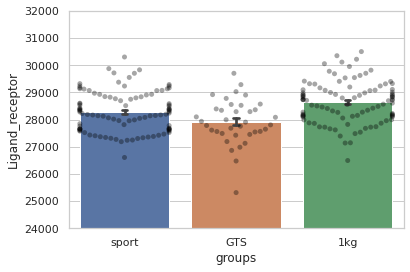

In [71]:
sns.set(style="whitegrid")

ax = sns.barplot(x='groups', y='Ligand_receptor', data=results_to_plot, capsize=.05, ci=68)
ax = sns.swarmplot(x='groups', y='Ligand_receptor', data=results_to_plot, color="0", alpha=.35)

ax.set(ylim=(24000, 32000))

plt.show()

/net/archive/groups/plggneuromol/imdik-zekanowski-gts/venv2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 26.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/archive/groups/plggneuromol/imdik-zekanowski-gts/venv2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 24.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


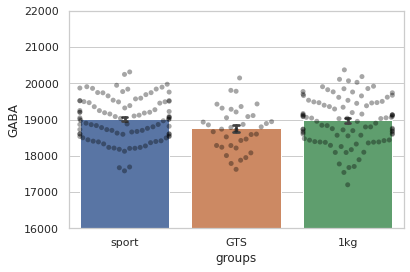

In [65]:
sns.set(style="whitegrid")

ax = sns.barplot(x='groups', y='GABA', data=results_to_plot, capsize=.05, ci=68)
ax = sns.swarmplot(x='groups', y='GABA', data=results_to_plot, color="0", alpha=.35)

ax.set(ylim=(16000, 22000))

plt.show()

In [59]:
p_gts_sport = []

for t in t_test_gts_sport:
    p_gts_sport.append(t[1])
    
p_gts_kg = []

for t in t_test_gts_1kg:
    p_gts_kg.append(t[1])
    
p_kg_sport = []

for t in t_test_sport_1kg:
    p_kg_sport.append(t[1])

In [14]:
list_results = pd.DataFrame([list(gene_lists.columns), p_gts_sport, p_gts_kg, p_kg_sport, 
                             gts_mean, gts_std, kg_mean, kg_std, sport_mean, sport_std])

In [15]:
list_results

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Cerebral_Cortex,Basal_Ganglia,Hypothalmus,Thalmus,Midbrain,Dopaminergiczna,Serotoninergiczna,Noradrenergiczna,GABA,SLITRK,...,Gutaminian,Serotonina_Kannabinoidy,Dopamina_Acetylocholina,geny_GTS,Synapsy,Tryptofan,Ligand_receptor,calcium,androgenowy,addiction
1,0.670815,0.716837,0.294448,0.825637,0.441012,0.216485,0.393911,0.09475,0.0232299,0.408466,...,0.801718,0.10099,0.247939,0.464668,0.561706,0.914488,0.0145159,0.110671,0.530526,0.0721212
2,0.590877,0.663069,0.941967,0.845396,0.00462156,0.0746287,0.063507,0.551048,0.0734026,0.219684,...,0.0611915,0.0265225,0.0223196,0.247403,0.00249376,0.906126,4.53654e-06,0.00498477,0.157093,0.00166465
3,0.192215,0.887912,0.178771,0.569245,0.00319447,0.369869,0.123996,0.00230461,0.654567,0.713865,...,0.0250101,0.378294,0.142822,0.683405,0.000912758,0.771227,0.00108096,0.0861634,0.265541,0.0637462
4,610.742,4481.45,474.007,1238.06,1440.28,3460.06,3414.44,1221.45,18760.6,14608.2,...,13189.5,3529.15,10587.7,11892.3,43623.1,6964.33,27925.7,39439.6,9578.07,8999.9
5,110.454,296.634,73.0761,165.369,144.742,268.163,205.016,139.366,582.436,728.591,...,532.292,216.861,328.917,701.694,1069.61,326.431,812.936,899.565,419.694,412.174
6,622.864,4506.09,473.047,1231.58,1358.42,3553.29,3503.32,1237.86,18979.5,14769.7,...,13386.6,3642.02,10762.4,12041.8,44234.1,6955.12,28644.5,39937.3,9703.51,9257.88
7,117.645,287.852,65.62,172.626,146.683,266.402,257.624,141.919,639.053,651.545,...,538.882,272.986,409.195,646.666,1000.06,426.131,757.69,895.435,465.62,413.896
8,601.783,4500.55,460.813,1244.35,1419.27,3520.48,3450.38,1173.1,19018.5,14731.8,...,13215.2,3608.5,10676,12000,43741.7,6972.24,28290.1,39717.3,9631.17,9146.78
9,107.768,261.09,61.2691,139.475,138.606,244.347,221.033,151.393,578.514,783.635,...,523.956,258.432,413.551,778.118,1045.79,397.077,738.057,889.81,441.36,420.183


In [16]:
list_results.to_csv('list_results.csv')

In [18]:
results = pd.read_csv('list_results.csv')

In [20]:
# graph results:
results

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0,Cerebral_Cortex,Basal_Ganglia,Hypothalmus,Thalmus,Midbrain,Dopaminergiczna,Serotoninergiczna,Noradrenergiczna,GABA,...,Gutaminian,Serotonina_Kannabinoidy,Dopamina_Acetylocholina,geny_GTS,Synapsy,Tryptofan,Ligand_receptor,calcium,androgenowy,addiction
1,1,0.6708147803802247,0.7168368888795273,0.2944481005981919,0.8256370228523174,0.4410119413641924,0.2164850983214534,0.39391128159986344,0.09475004709962802,0.023229872806479805,...,0.8017176448041692,0.10099022963229952,0.2479389782925463,0.46466802867457513,0.5617058519591214,0.9144880303186128,0.014515853941438476,0.11067064929977027,0.5305256345557436,0.07212116821232717
2,2,0.590877452314323,0.6630685181007154,0.9419669154115095,0.8453959810074898,0.004621560517470605,0.07462865837277784,0.06350704175476739,0.5510476054252794,0.0734026404922554,...,0.06119149346595625,0.026522459980516888,0.022319589268509247,0.24740346202210428,0.002493761864175915,0.9061262593840894,4.5365390648835154e-06,0.0049847684809844785,0.15709326714835647,0.0016646492828673708
3,3,0.19221484468155486,0.8879123749356086,0.17877106486244665,0.5692445912242436,0.00319446649734816,0.3698692454808502,0.12399578588479741,0.0023046077415359583,0.6545667273590818,...,0.02501013668650194,0.37829381087985225,0.14282174843017667,0.6834050013728982,0.0009127584821406958,0.7712273722101771,0.0010809600166122757,0.08616337279855107,0.2655414031642979,0.0637461689257033
4,4,610.7419189189188,4481.445999999999,474.0071351351351,1238.0641621621623,1440.280054054054,3460.0636486486483,3414.4366756756754,1221.4502702702703,18760.57621621622,...,13189.490054054055,3529.145432432432,10587.665297297297,11892.262324324325,43623.080729729736,6964.334918918919,27925.736594594597,39439.55037837838,9578.067594594595,8999.902000000002
5,5,110.45445174452053,296.63428204176313,73.07610190500303,165.36927937203984,144.7420476219017,268.1628914916208,205.01588229538297,139.36594425015664,582.4360186159013,...,532.2923114467226,216.8614705537431,328.9168375683112,701.6939456463618,1069.6116261961529,326.4313777938613,812.9362686070336,899.5646241527024,419.69389071846547,412.17381113947965
6,6,622.8641428571428,4506.087061224489,473.04660204081625,1231.5820204081633,1358.42243877551,3553.2885510204087,3503.318306122449,1237.8597959183674,18979.497612244897,...,13386.62336734694,3642.021275510204,10762.424591836734,12041.820744897961,44234.11622448979,6955.118193877551,28644.54469387755,39937.26759183673,9703.513326530612,9257.879795918368
7,7,117.6452577735807,287.85214289988784,65.61999462330088,172.6256704544742,146.68252546168435,266.4023122740139,257.6240635214304,141.91942847996816,639.0531611658254,...,538.8817711340768,272.986025367405,409.19473474460887,646.6660817552911,1000.0630450303408,426.13112476459133,757.6901582732689,895.4353593682553,465.620393196173,413.8962763892136
8,8,601.78305,4500.54921,460.8129,1244.3503699999999,1419.2651999999998,3520.4809700000005,3450.3841299999995,1173.0974800000001,19018.500139999996,...,13215.156470000002,3608.4973000000005,10675.951349999998,12000.037640000004,43741.74472999999,6972.244730000001,28290.057790000006,39717.336610000006,9631.16652,9146.780810000002
9,9,107.76821707965433,261.08992345604946,61.269054182596946,139.4745886346796,138.6060685237122,244.34749485089682,221.03279775914046,151.39338843433555,578.5136298939557,...,523.9560484883339,258.4315194704199,413.55142048184024,778.1181101469432,1045.7915510729265,397.07686930849655,738.0567904435577,889.8098833689793,441.3598800345468,420.18341166901627


## Run per gene tests for GABA and ligand-receptor lists

In [79]:
# run per gene tests:

per_gene = per_gene.annotate_rows(gaba = hl.literal(genes[8]).contains(per_gene.within_gene))

In [81]:
results = per_gene.filter_rows(per_gene.gaba)
gaba_genes = results.within_gene.collect()

In [82]:
print(gaba_genes)

['ABAT', 'ALDH5A1', 'ARHGEF11', 'CNR1', 'DBI', 'DLX5', 'DRD5', 'ERBB4', 'GABARAP', 'GABARAPL1', 'GABARAPL3', 'GABBR2', 'GABRA1', 'GABRA2', 'GABRA4', 'GABRA5', 'GABRA6', 'GABRB1', 'GABRB2', 'GABRB3', 'GABRD', 'GABRG1', 'GABRG2', 'GABRG3', 'GABRP', 'GABRR1', 'GABRR2', 'GABRR3', 'GAD1', 'GAD2', 'GPHN', 'GPR156', 'GPR158', 'GPRC5B', 'GPRC5C', 'GPRC5D', 'GRIK1', 'GRM5', 'HAP1', 'HSD17B10', 'IL11', 'IL11RA', 'IL1R1', 'IL1RN', 'INMT', 'JAKMIP1', 'KCTD16', 'ME2', 'MECP2', 'NBEA', 'NF1', 'NFATC4', 'NPTN', 'OSR1', 'PDXP', 'PRKCE', 'SGCE', 'SLC10A4', 'SLC11A2', 'SLC12A2', 'SLC12A5', 'SLC1A1', 'SLC1A2', 'SLC1A3', 'SLC1A6', 'SLC1A7', 'SLC29A4', 'SLC32A1', 'SLC6A1', 'SLC6A11', 'SLC6A12', 'SLC6A13', 'SLC6A6', 'SPTBN2', 'STK39', 'SYT1', 'TRAK2', 'TRH', 'UBQLN1', 'ZDHHC3']


In [83]:
len(gaba_genes)

80

In [89]:
t_test_gts_sport = []
t_test_gts_1kg = []
t_test_sport_1kg = []
gts_mean = []
gts_std = []
kg_mean = []
kg_std = []
sport_mean = []
sport_std = []

for g in gaba_genes:
    result = per_gene.filter_rows(per_gene.within_gene == g)
    print(result.count())
    print('the gene is:'+g)
    r = result['burden_cadd_phred'].collect()
    
    x = np.array(r)[np.array(groups) == 'GTS']
    y = np.array(r)[np.array(groups) == 'sport']
    t_test_gts_sport.append(stats.ttest_ind(x,y))
    x = np.array(r)[np.array(groups) == 'GTS']
    y = np.array(r)[np.array(groups) == '1kg']
    t_test_gts_1kg.append(stats.ttest_ind(x,y))
    x = np.array(r)[np.array(groups) == 'sport']
    y = np.array(r)[np.array(groups) == '1kg']
    t_test_sport_1kg.append(stats.ttest_ind(x,y))
    gts_mean.append(np.mean((np.array(r)[np.array(groups) == 'GTS'])))
    gts_std.append(np.std(np.array(r)[np.array(groups) == 'GTS']))
    kg_mean.append(np.mean((np.array(r)[np.array(groups) == '1kg'])))
    kg_std.append(np.std(np.array(r)[np.array(groups) == '1kg']))
    sport_mean.append(np.mean((np.array(r)[np.array(groups) == 'sport'])))
    sport_std.append(np.std(np.array(r)[np.array(groups) == 'sport']))

(1, 235)
the gene is:ABAT
(1, 235)
the gene is:ALDH5A1
(1, 235)
the gene is:ARHGEF11
(1, 235)
the gene is:CNR1
(1, 235)
the gene is:DBI
(1, 235)
the gene is:DLX5
(1, 235)
the gene is:DRD5
(1, 235)
the gene is:ERBB4
(1, 235)
the gene is:GABARAP
(1, 235)
the gene is:GABARAPL1
(1, 235)
the gene is:GABARAPL3
(1, 235)
the gene is:GABBR2
(1, 235)
the gene is:GABRA1
(1, 235)
the gene is:GABRA2
(1, 235)
the gene is:GABRA4
(1, 235)
the gene is:GABRA5
(1, 235)
the gene is:GABRA6
(1, 235)
the gene is:GABRB1
(1, 235)
the gene is:GABRB2
(1, 235)
the gene is:GABRB3
(1, 235)
the gene is:GABRD
(1, 235)
the gene is:GABRG1
(1, 235)
the gene is:GABRG2
(1, 235)
the gene is:GABRG3
(1, 235)
the gene is:GABRP
(1, 235)
the gene is:GABRR1
(1, 235)
the gene is:GABRR2
(1, 235)
the gene is:GABRR3
(1, 235)
the gene is:GAD1
(1, 235)
the gene is:GAD2
(1, 235)
the gene is:GPHN
(1, 235)
the gene is:GPR156
(1, 235)
the gene is:GPR158
(1, 235)
the gene is:GPRC5B
(1, 235)
the gene is:GPRC5C
(1, 235)
the gene is:GPRC5D
(1

In [92]:
p_gts_sport = []

for t in t_test_gts_sport:
    p_gts_sport.append(t[1])
    
p_gts_kg = []

for t in t_test_gts_1kg:
    p_gts_kg.append(t[1])
    
p_kg_sport = []

for t in t_test_sport_1kg:
    p_kg_sport.append(t[1])

In [97]:
list_results = pd.DataFrame([gaba_genes, p_gts_sport, p_gts_kg, p_kg_sport, 
                             gts_mean, gts_std, kg_mean, kg_std, sport_mean, sport_std])

In [99]:
list_results = list_results.transpose()

In [101]:
list_results.to_csv('gaba_results.csv')

## Ligand_receptor

In [14]:
# run per gene tests:

per_gene = per_gene.annotate_rows(lr = hl.literal(genes[17]).contains(per_gene.within_gene))

In [15]:
results = per_gene.filter_rows(per_gene.lr)
lr = results.within_gene.collect()

In [16]:
print(lr)

['ADCYAP1R1', 'AGTR1', 'APLNR', 'AVPR1A', 'AVPR1B', 'BDKRB1', 'BDKRB2', 'C3AR1', 'C5AR1', 'CALCR', 'CALCRL', 'CCKAR', 'CCKBR', 'CGA', 'CHRNA1', 'CHRNA10', 'CHRNA2', 'CHRNA7', 'CHRNA9', 'CHRNB1', 'CHRNB3', 'CHRNB4', 'CHRND', 'CHRNE', 'CHRNG', 'CRHR2', 'CTSG', 'CYSLTR2', 'EDNRA', 'EDNRB', 'F2', 'F2R', 'F2RL1', 'F2RL2', 'F2RL3', 'FPR1', 'FPR2', 'FPR3', 'FSHB', 'FSHR', 'GABBR2', 'GABRA1', 'GABRA2', 'GABRA4', 'GABRA5', 'GABRA6', 'GABRB1', 'GABRB2', 'GABRB3', 'GABRD', 'GABRG1', 'GABRG2', 'GABRG3', 'GABRP', 'GABRR1', 'GABRR2', 'GALR1', 'GALR3', 'GCGR', 'GH1', 'GH2', 'GHR', 'GHRHR', 'GHSR', 'GIPR', 'GLP1R', 'GLP2R', 'GLRA1', 'GLRA3', 'GLRB', 'GNRHR', 'GPR156', 'GPR35', 'GPR83', 'GRID1', 'GRID2', 'GRIK1', 'GRIK2', 'GRIK3', 'GRIK4', 'GRIK5', 'GRM1', 'GRM2', 'GRM3', 'GRM4', 'GRM5', 'GRM6', 'GRM7', 'GRM8', 'GZMA', 'HCRTR1', 'HCRTR2', 'KISS1R', 'LEP', 'LEPR', 'LHB', 'LHCGR', 'LPAR1', 'LPAR2', 'LPAR3', 'LPAR6', 'LTB4R', 'LTB4R2', 'MAS1', 'MC1R', 'MC2R', 'MC5R', 'MCHR1', 'MCHR2', 'MLNR', 'MTNR1A', 'M

In [17]:
len(lr)

187

In [18]:
t_test_gts_sport = []
t_test_gts_1kg = []
t_test_sport_1kg = []
gts_mean = []
gts_std = []
kg_mean = []
kg_std = []
sport_mean = []
sport_std = []

for g in lr:
    result = per_gene.filter_rows(per_gene.within_gene == g)
    print(result.count())
    print('the gene is:'+g)
    r = result['burden_cadd_phred'].collect()
    
    x = np.array(r)[np.array(groups) == 'GTS']
    y = np.array(r)[np.array(groups) == 'sport']
    t_test_gts_sport.append(stats.ttest_ind(x,y))
    x = np.array(r)[np.array(groups) == 'GTS']
    y = np.array(r)[np.array(groups) == '1kg']
    t_test_gts_1kg.append(stats.ttest_ind(x,y))
    x = np.array(r)[np.array(groups) == 'sport']
    y = np.array(r)[np.array(groups) == '1kg']
    t_test_sport_1kg.append(stats.ttest_ind(x,y))
    gts_mean.append(np.mean((np.array(r)[np.array(groups) == 'GTS'])))
    gts_std.append(np.std(np.array(r)[np.array(groups) == 'GTS']))
    kg_mean.append(np.mean((np.array(r)[np.array(groups) == '1kg'])))
    kg_std.append(np.std(np.array(r)[np.array(groups) == '1kg']))
    sport_mean.append(np.mean((np.array(r)[np.array(groups) == 'sport'])))
    sport_std.append(np.std(np.array(r)[np.array(groups) == 'sport']))

(1, 235)
the gene is:ADCYAP1R1
(1, 235)
the gene is:AGTR1
(1, 235)
the gene is:APLNR
(1, 235)
the gene is:AVPR1A
(1, 235)
the gene is:AVPR1B
(1, 235)
the gene is:BDKRB1
(1, 235)
the gene is:BDKRB2
(1, 235)
the gene is:C3AR1
(1, 235)
the gene is:C5AR1
(1, 235)
the gene is:CALCR
(1, 235)
the gene is:CALCRL
(1, 235)
the gene is:CCKAR
(1, 235)
the gene is:CCKBR
(1, 235)
the gene is:CGA
(1, 235)
the gene is:CHRNA1
(1, 235)
the gene is:CHRNA10
(1, 235)
the gene is:CHRNA2
(1, 235)
the gene is:CHRNA7
(1, 235)
the gene is:CHRNA9
(1, 235)
the gene is:CHRNB1
(1, 235)
the gene is:CHRNB3
(1, 235)
the gene is:CHRNB4
(1, 235)
the gene is:CHRND
(1, 235)
the gene is:CHRNE
(1, 235)
the gene is:CHRNG
(1, 235)
the gene is:CRHR2
(1, 235)
the gene is:CTSG
(1, 235)
the gene is:CYSLTR2
(1, 235)
the gene is:EDNRA
(1, 235)
the gene is:EDNRB
(1, 235)
the gene is:F2
(1, 235)
the gene is:F2R
(1, 235)
the gene is:F2RL1
(1, 235)
the gene is:F2RL2
(1, 235)
the gene is:F2RL3
(1, 235)
the gene is:FPR1
(1, 235)
the gene

In [19]:
p_gts_sport = []

for t in t_test_gts_sport:
    p_gts_sport.append(t[1])
    
p_gts_kg = []

for t in t_test_gts_1kg:
    p_gts_kg.append(t[1])
    
p_kg_sport = []

for t in t_test_sport_1kg:
    p_kg_sport.append(t[1])

In [21]:
list_results = pd.DataFrame([lr, p_gts_sport, p_gts_kg, p_kg_sport, 
                             gts_mean, gts_std, kg_mean, kg_std, sport_mean, sport_std])

In [22]:
list_results = list_results.transpose()

In [23]:
list_results.to_csv('lr_results.csv')